<a href="https://colab.research.google.com/github/Damilolaori/Final-Project-/blob/main/Oluwadamilola_Abimbola_Orimoogunje_21019292.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# install libraries
!pip install keras-tuner
!pip install ta

# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from scipy.stats import t, skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

<ipython-input-24-c80a1c68fde1>:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# Setting stocks and intervals
stocks = ["VOD.L", "HSBA.L", "SHEL.L"]
start_date = "2013-01-01"
end_date = "2023-12-31"

In [3]:
# Initialize an empty list to collect DataFrames
stock_data_list = []

# Loop through each stock, download the data, and add it to the list
for stock in stocks:
    data = yf.download(stock, start=start_date, end=end_date)
    data['Stock'] = stock
    stock_data_list.append(data)

# Concatenate all the DataFrames in the list into a single DataFrame
stock_data = pd.concat(stock_data_list)

# Display the resulting DataFrame
stock_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Stock
Date,,,,,,,
2013-01-02,163.537201,165.153198,161.034805,164.162704,69.963257,83340593,VOD.L
2013-01-03,164.631897,164.830002,162.598801,164.110596,69.941048,71870539,VOD.L
2013-01-04,163.693497,169.288300,163.693497,166.873596,71.118591,76183361,VOD.L
2013-01-07,166.456497,168.106995,166.352295,166.456497,70.940826,71771713,VOD.L
2013-01-08,170.053604,171.767700,169.323807,169.323807,72.162842,140972109,VOD.L


In [4]:
# Basic Statistics
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,8331.000000,8331.000000,8331.000000,8331.000000,8331.000000,8.331000e+03
mean,935.307695,944.565694,925.288769,935.099725,687.086505,4.007820e+07
std,845.083933,853.012738,837.197642,845.005188,671.681078,4.575528e+07
min,66.019997,66.480003,3.045000,64.720001,60.919899,0.000000e+00
25%,218.000000,220.025002,215.715996,217.850006,112.252518,1.072821e+07
50%,607.099976,612.099976,601.799988,606.700012,395.416504,2.610217e+07
75%,1804.000000,1820.500000,1777.750000,1805.000000,1202.597717,5.443034e+07
max,2784.500000,2801.000000,2757.500000,2772.500000,2682.701660,9.423232e+08


In [5]:
# checking missing values
stock_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Stock        0
dtype: int64

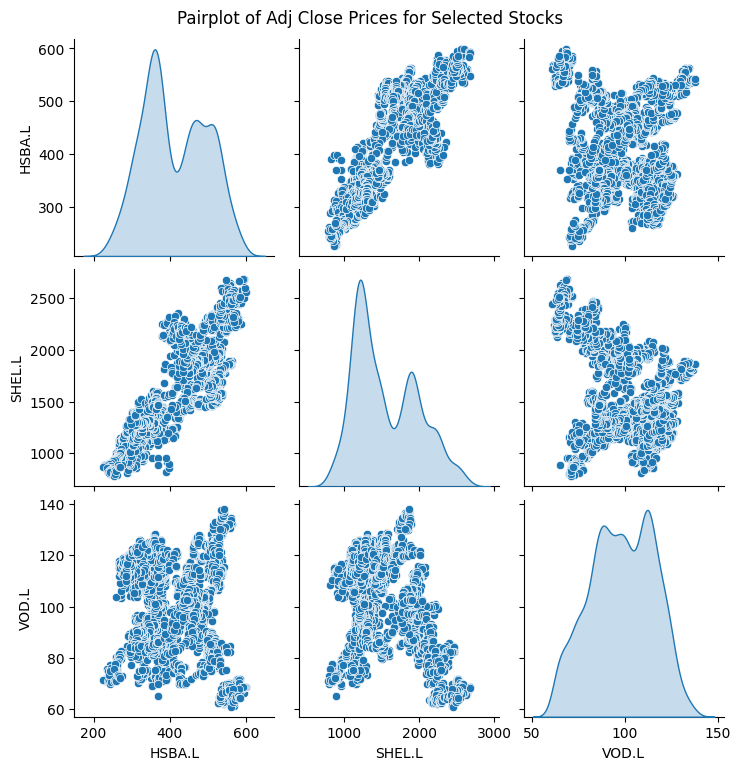

In [6]:
# Pivot the data to have 'Date' as the index and 'Stock' as columns for 'Adj Close'
adj_close_data = stock_data.pivot_table(index='Date', columns='Stock', values='Adj Close')

# Reset index to make 'Date' a column again (for seaborn compatibility)
adj_close_data.reset_index(inplace=True)

# Plotting the pairplot
sns.pairplot(adj_close_data, diag_kind='kde')
plt.suptitle('Pairplot of Adj Close Prices for Selected Stocks', y=1.02)
plt.show()


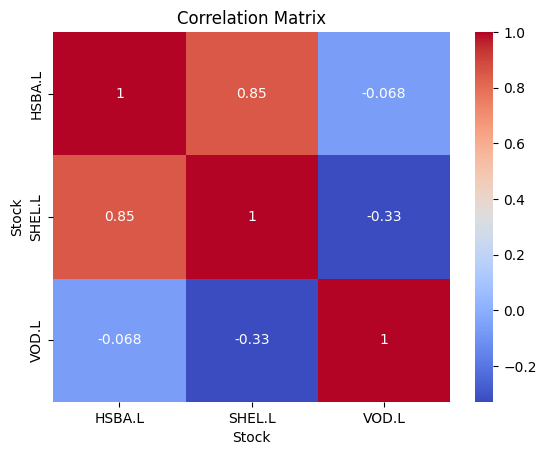

In [7]:
# Correlation Analysis
# Pivot the data to get a DataFrame with stocks as columns
pivot_data = stock_data.pivot_table(index='Date', columns='Stock', values='Adj Close')

# Calculate the correlation matrix
correlation_matrix = pivot_data.corr()

# Plot the correlation matrix using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

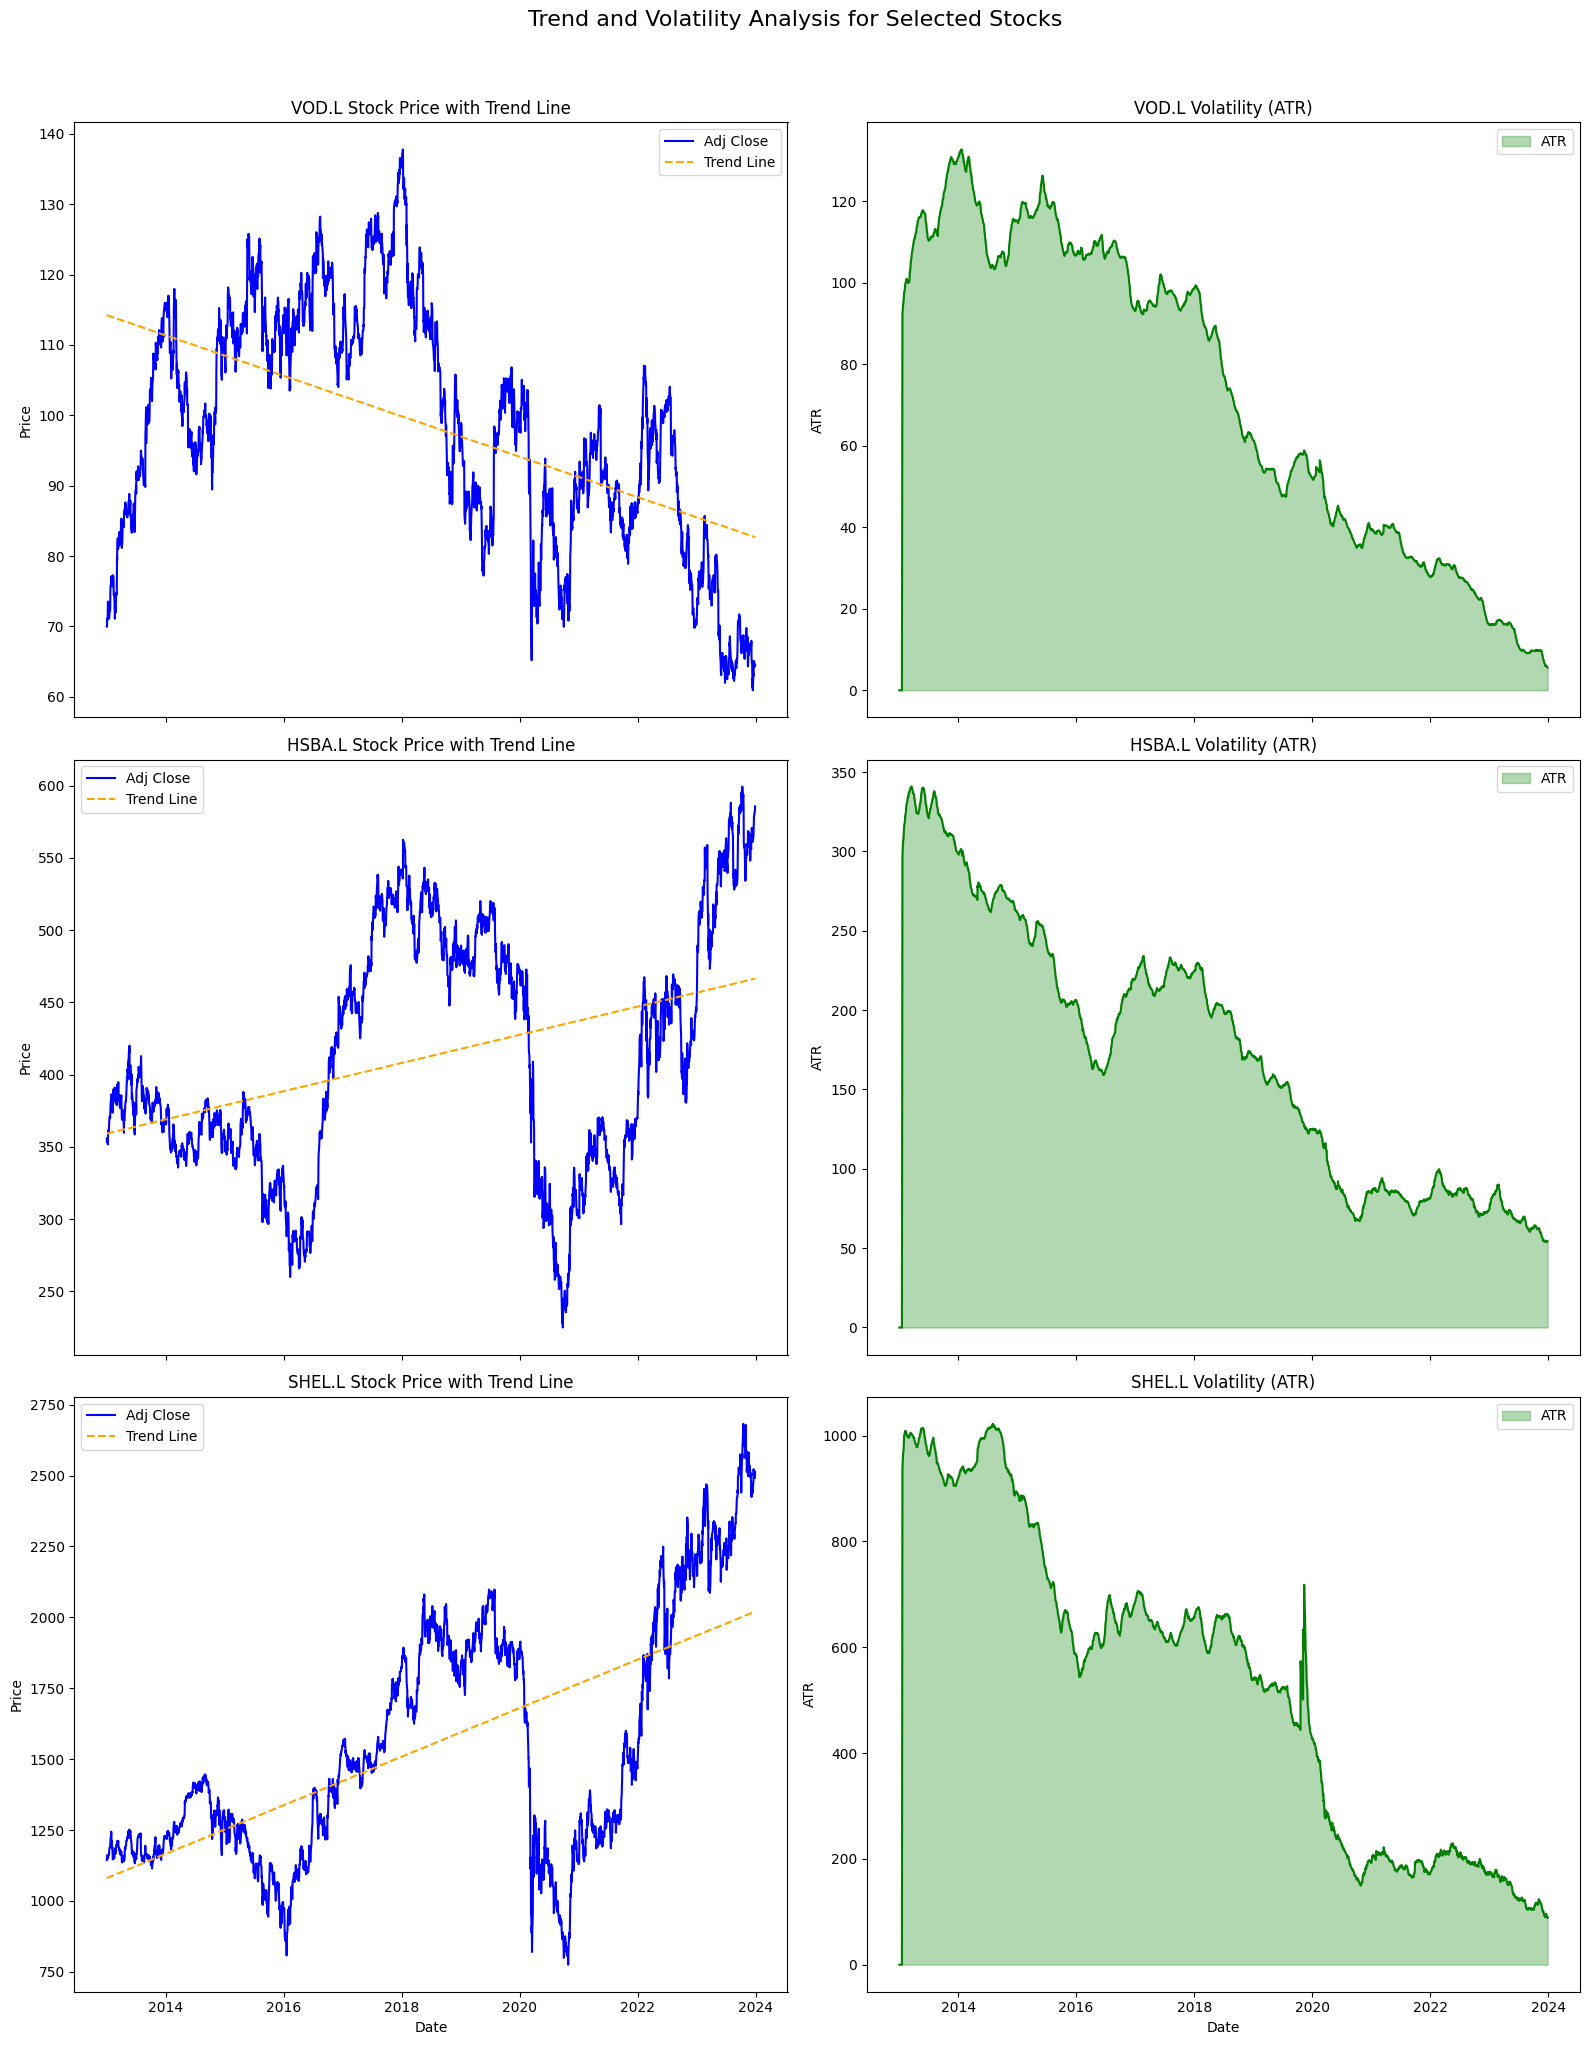

In [8]:
# Initialize subplots with proper figure size and spacing
fig, axs = plt.subplots(len(stocks), 2, figsize=(16, 20), sharex='col')

# Loop through each stock for analysis
for i, stock in enumerate(stocks):
    # Subset data for the current stock
    stock_data_subset = stock_data[stock_data['Stock'] == stock]
    dates = np.array(range(len(stock_data_subset)))

    # Trend analysis using linear regression
    close_prices = stock_data_subset['Adj Close']
    slope, intercept, r_value, p_value, std_err = linregress(dates, close_prices)
    trend_line = slope * dates + intercept

    # Plotting trend line
    axs[i, 0].plot(stock_data_subset.index, close_prices, label='Adj Close', color='blue')
    axs[i, 0].plot(stock_data_subset.index, trend_line, label='Trend Line', linestyle='--', color='orange')
    axs[i, 0].set_title(f'{stock} Stock Price with Trend Line')
    axs[i, 0].set_ylabel('Price')
    axs[i, 0].legend()

    # Volatility analysis using Average True Range (ATR)
    atr_indicator = AverageTrueRange(high=stock_data_subset['High'], low=stock_data_subset['Low'],
                                     close=stock_data_subset['Adj Close'], window=14)
    atr_values = atr_indicator.average_true_range()

    # Plotting ATR
    axs[i, 1].fill_between(stock_data_subset.index, 0, atr_values, label='ATR', color='green', alpha=0.3)
    axs[i, 1].plot(stock_data_subset.index, atr_values, linestyle='-', color='green')
    axs[i, 1].set_title(f'{stock} Volatility (ATR)')
    axs[i, 1].set_ylabel('ATR')
    axs[i, 1].legend()

# Set common X-axis label for the last row of subplots
for ax in axs[-1, :]:
    ax.set_xlabel('Date')

# Adjust layout, add overall title, and display
plt.suptitle('Trend and Volatility Analysis for Selected Stocks', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# define a function that plot a T distribution of the stock data
def T_distribution_plot(stock, ax):
    """This plots t-distribution using the returns of each stocks"""
    returns = stock_data[stock_data['Stock'] == stock]['Adj Close'].pct_change().dropna()

    x_list = np.linspace(returns.min(), returns.max(), 100)
    params = t.fit(returns)
    df, loc, scale = params
    y_list = t.pdf(x_list, df, loc, scale)

    ax.plot(x_list, y_list, label='T Dist')
    ax.hist(returns, bins=100, density=True, alpha=0.5, label=f'{stock} Returns')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'T Distribution of Returns for {stock}')
    ax.legend(bbox_to_anchor=(1.0, 1.0))

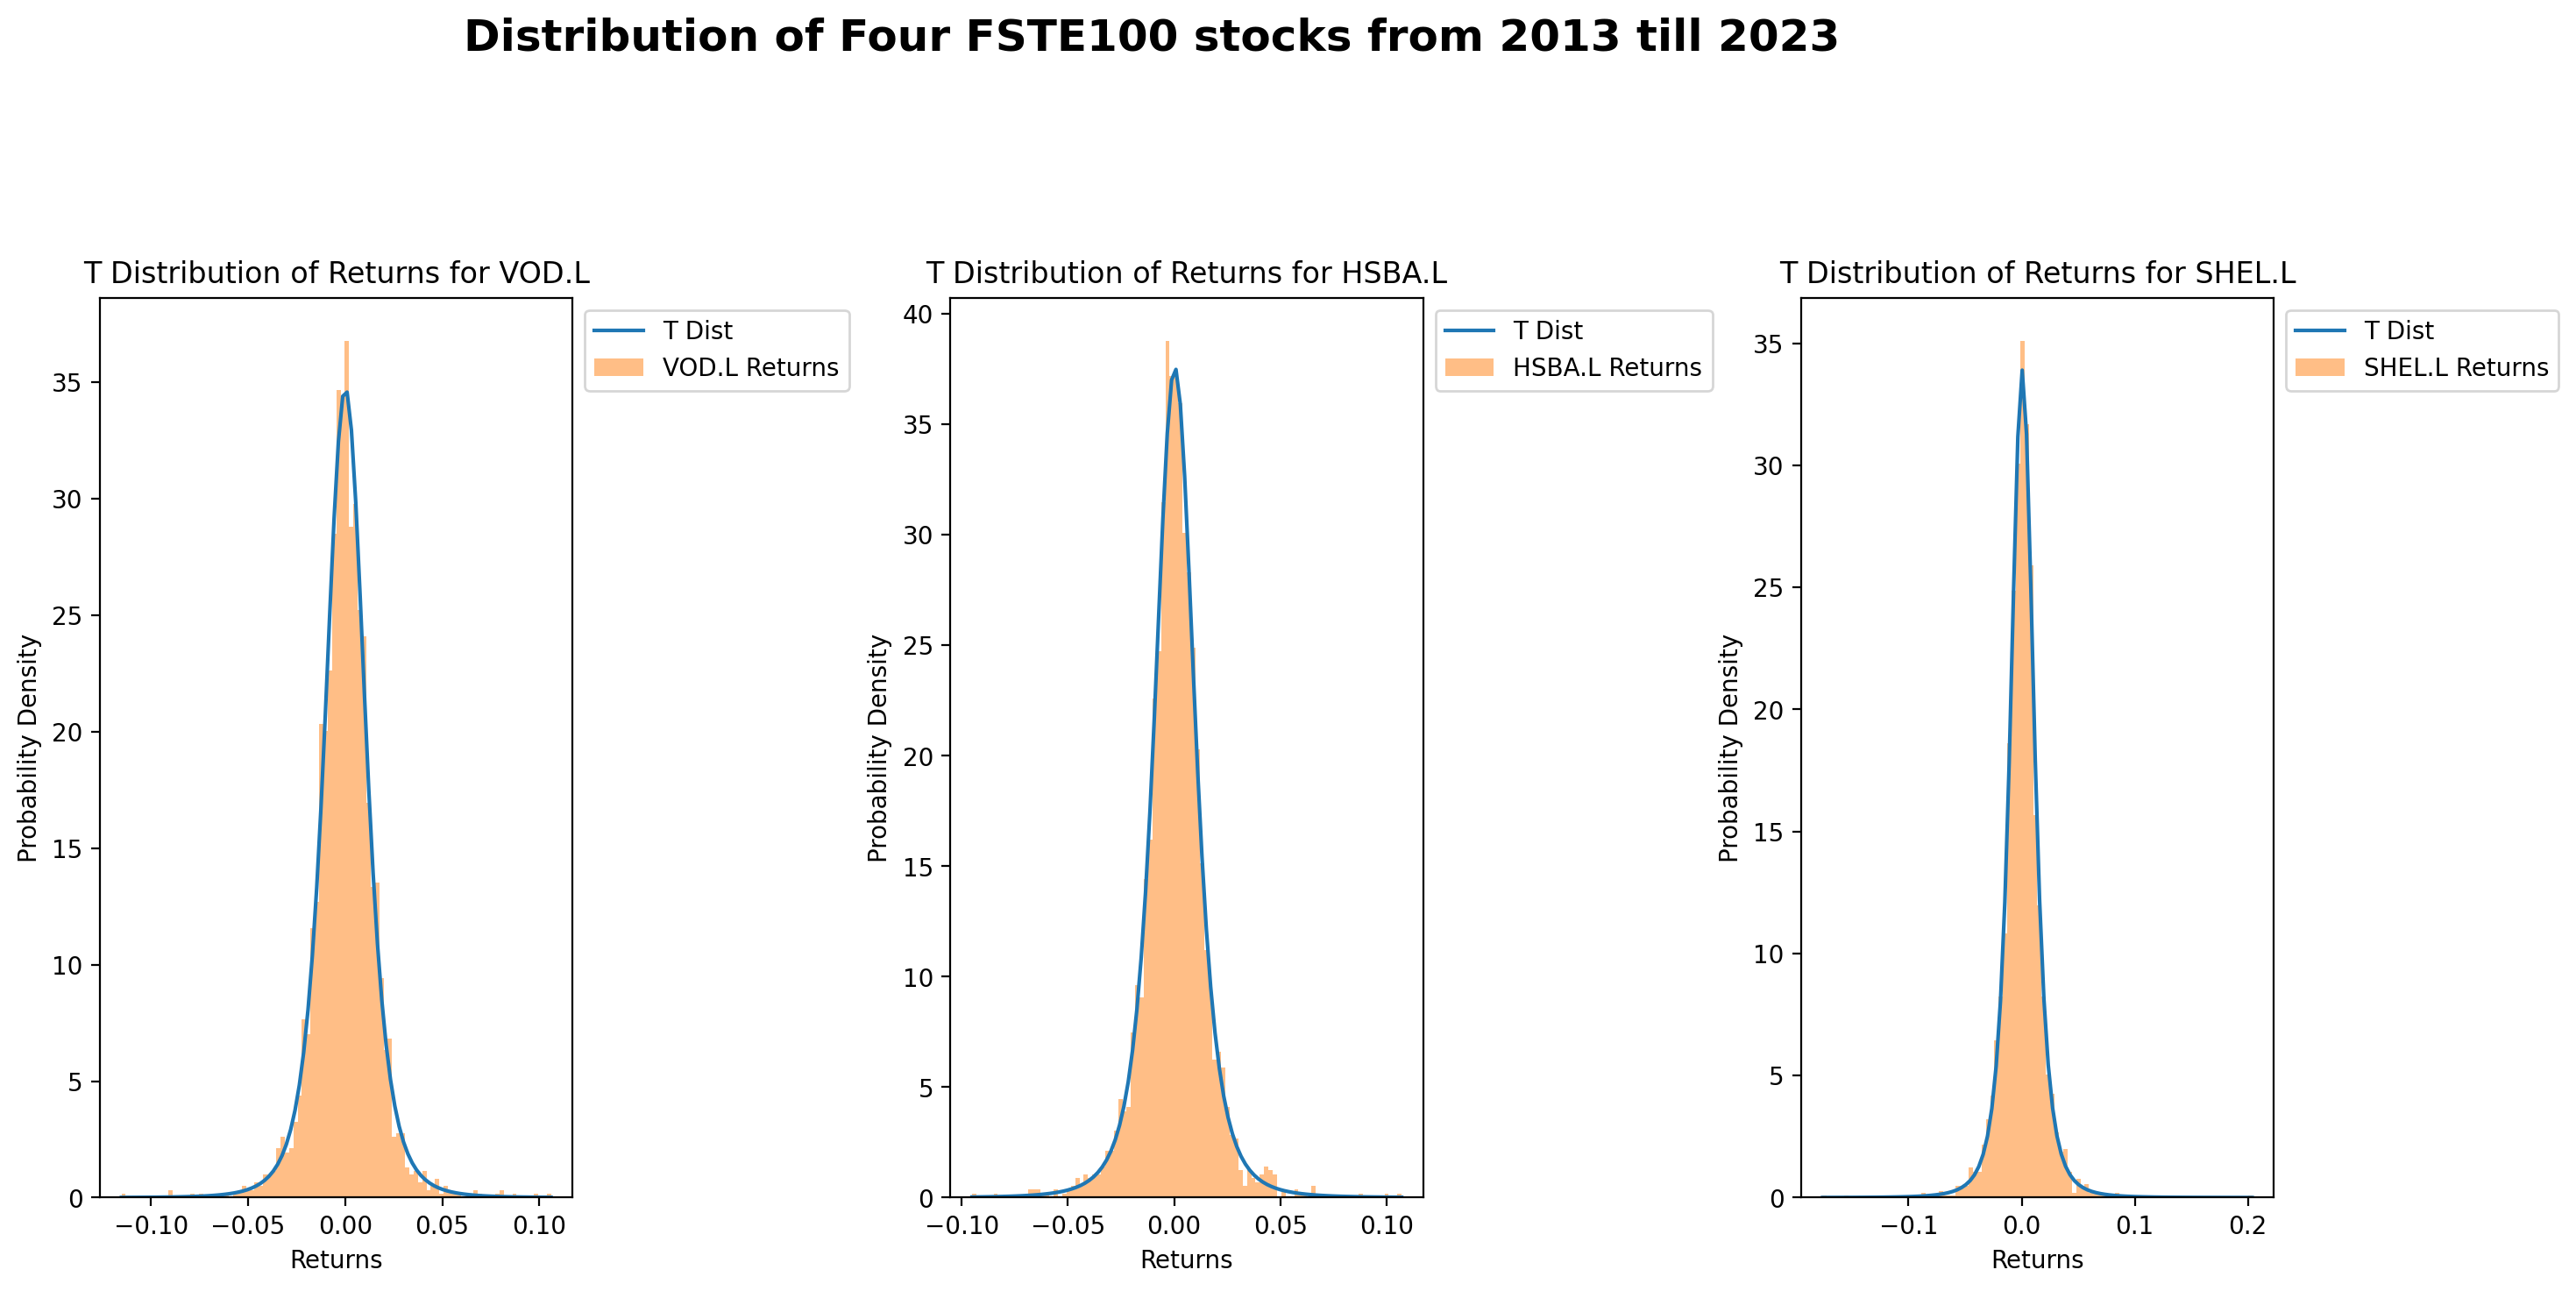

In [10]:
# create a gridspec with rows 2 and 3 columns for distribution of the stocks
fig = plt.figure(figsize=(16,16), dpi=200)
fig.suptitle('Distribution of Four FSTE100 stocks from 2013 till 2023', fontsize=18, fontweight='bold')
gs = fig.add_gridspec(nrows=2, ncols=3, wspace=0.8, hspace=0.4)

# Plot distribution for VOD.L
ax1 = plt.subplot(gs[0,0])
T_distribution_plot('VOD.L', ax=ax1)

# Plot distribution for MKS
ax2 = plt.subplot(gs[0,1])
T_distribution_plot('HSBA.L', ax=ax2)

# Plot distribution for HSBA
ax3 = plt.subplot(gs[0,2])
T_distribution_plot('SHEL.L', ax=ax3)

plt.show()

In [11]:
# the returns dataframe is used to calculate the skewness and kurtosis of each stock
# create dataframe stock name in the 'stock' column
stock_names = pd.DataFrame({'Stock': ['VOD.L', 'HSBA.L', 'SHEL.L',]})

# Empty DataFrame to store returns
stock_returns = pd.DataFrame()
# Loop through stock names and calculate returns
for stock in stock_names['Stock']:
  returns = stock_data[stock_data['Stock'] == stock]['Adj Close'].pct_change()
  # Add returns to the DataFrame
  stock_returns[stock] = returns

# check the first 5 rows of the stock returns dataframe
stock_returns.head()

,VOD.L,HSBA.L,SHEL.L
Date,,,
2013-01-02,NaN,NaN,NaN
2013-01-03,-0.000317,-0.004807,0.007299
2013-01-04,0.016836,0.007698,0.007247
2013-01-07,-0.002500,-0.002097,-0.006266
2013-01-08,0.017226,-0.010507,-0.004204


In [12]:
# the returns dataframe is used to calculate the skewness and kurtosis of each stock
# create dataframe stock name in the 'stock' column
stock_names = pd.DataFrame({'Stock': ['VOD.L', 'HSBA.L', 'SHEL.L',]})

# Empty DataFrame to store returns
stock_returns = pd.DataFrame()
# Loop through stock names and calculate returns
for stock in stock_names['Stock']:
  returns = stock_data[stock_data['Stock'] == stock]['Adj Close'].pct_change()
  # Add returns to the DataFrame
  stock_returns[stock] = returns

# check the first 5 rows of the stock returns dataframe
stock_returns.head()

,VOD.L,HSBA.L,SHEL.L
Date,,,
2013-01-02,NaN,NaN,NaN
2013-01-03,-0.000317,-0.004807,0.007299
2013-01-04,0.016836,0.007698,0.007247
2013-01-07,-0.002500,-0.002097,-0.006266
2013-01-08,0.017226,-0.010507,-0.004204


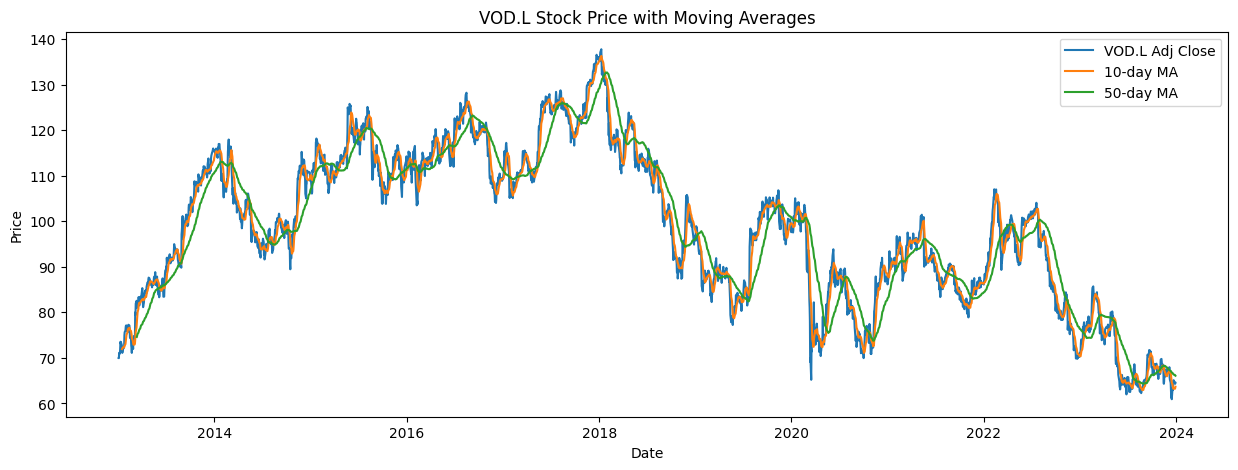

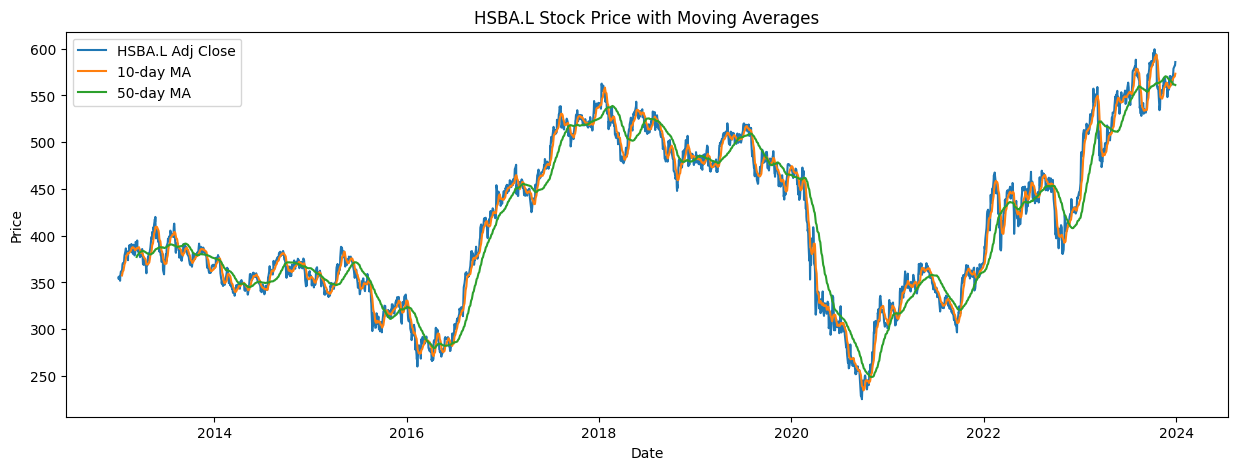

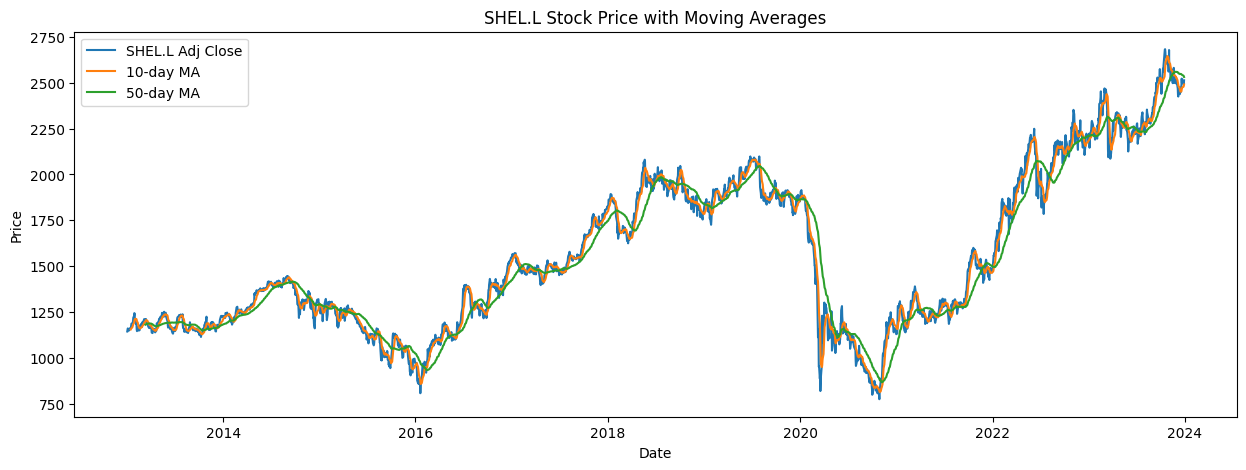

In [13]:
# Moving Averages
short_window = 10
long_window = 50


# Calculate moving averages and plot for each stock
for stock in stocks:
    stock_data_subset = stock_data[stock_data['Stock'] == stock].copy()
    stock_data_subset.loc[:, f'{short_window}-day MA'] = stock_data_subset['Adj Close'].rolling(window=short_window).mean()
    stock_data_subset.loc[:, f'{long_window}-day MA'] = stock_data_subset['Adj Close'].rolling(window=long_window).mean()

    plt.figure(figsize=(15, 5))
    plt.plot(stock_data_subset.index, stock_data_subset['Adj Close'], label=f'{stock} Adj Close')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{short_window}-day MA'], label=f'{short_window}-day MA')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{long_window}-day MA'], label=f'{long_window}-day MA')
    plt.title(f'{stock} Stock Price with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

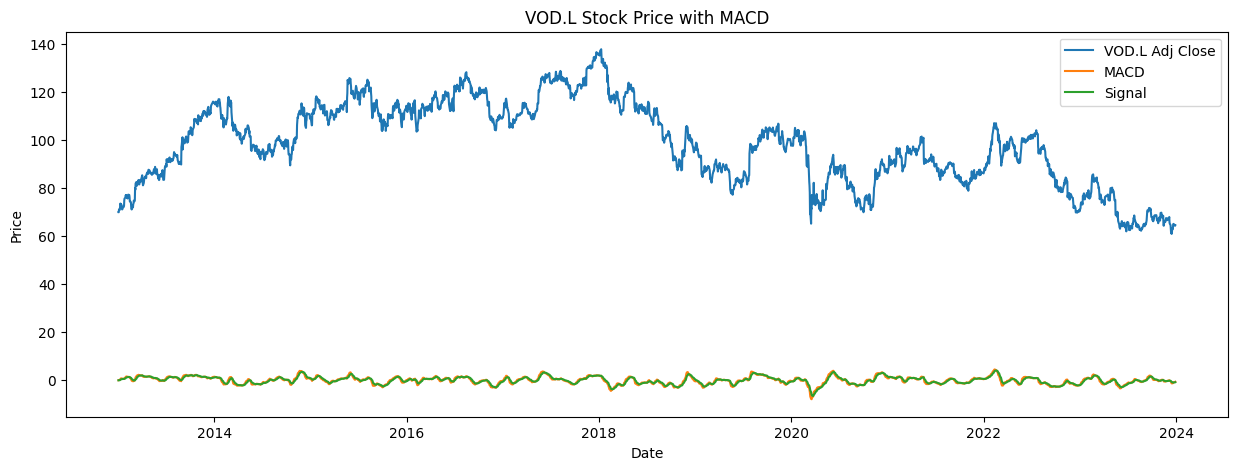

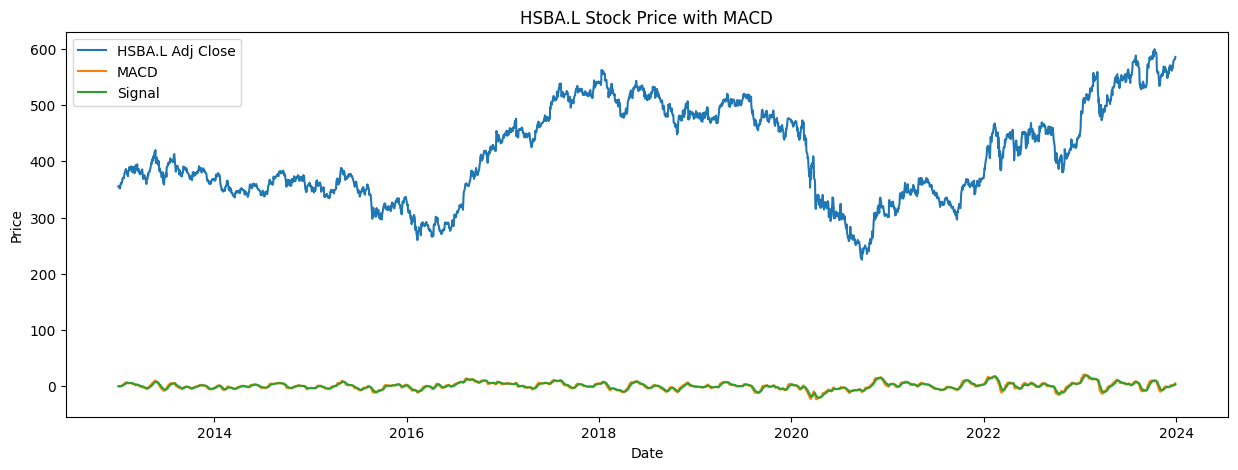

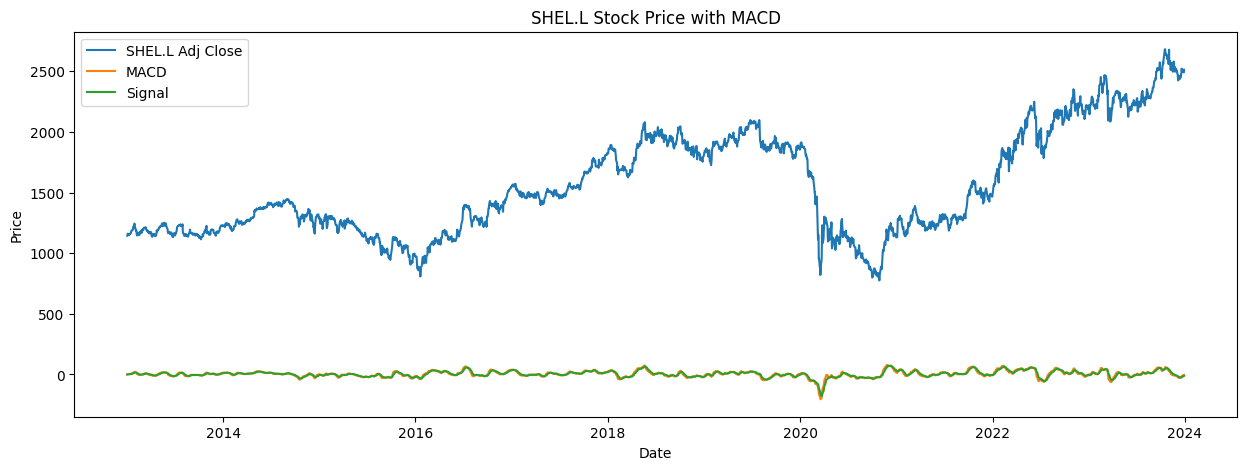

In [14]:
# MACD parameters
fast_period = 12
slow_period = 26
signal_period = 9

# Calculate MACD and plot for each stock
for stock in stocks:
    stock_data_subset = stock_data[stock_data['Stock'] == stock].copy()
    exp1 = stock_data_subset['Adj Close'].ewm(span=fast_period, adjust=False).mean()
    exp2 = stock_data_subset['Adj Close'].ewm(span=slow_period, adjust=False).mean()
    stock_data_subset[f'{stock}_MACD'] = exp1 - exp2
    stock_data_subset[f'{stock}_MACD_Signal'] = stock_data_subset[f'{stock}_MACD'].ewm(span=signal_period, adjust=False).mean()

    plt.figure(figsize=(15, 5))
    plt.plot(stock_data_subset.index, stock_data_subset['Adj Close'], label=f'{stock} Adj Close')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_MACD'], label='MACD')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_MACD_Signal'], label='Signal')
    plt.title(f'{stock} Stock Price with MACD')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

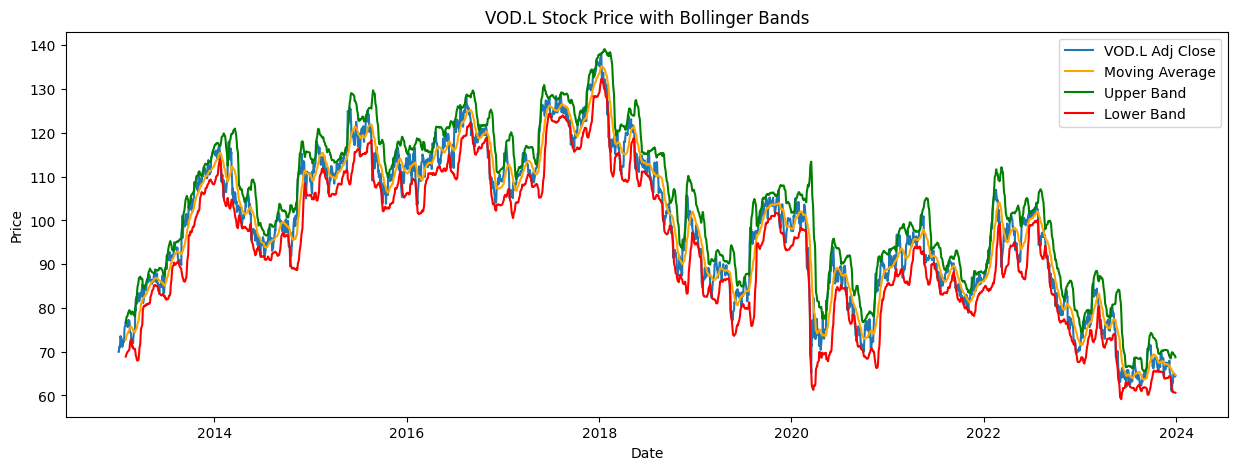

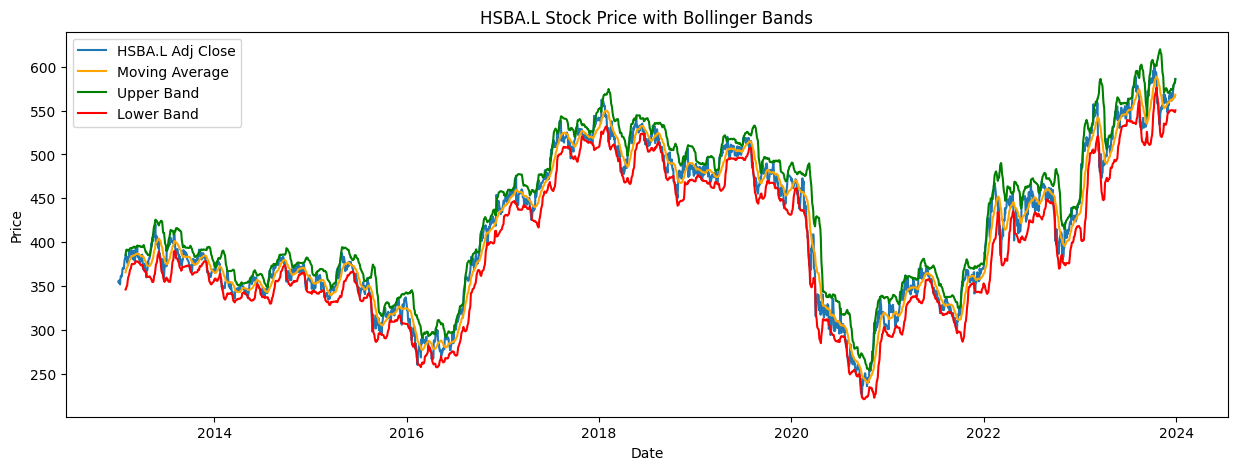

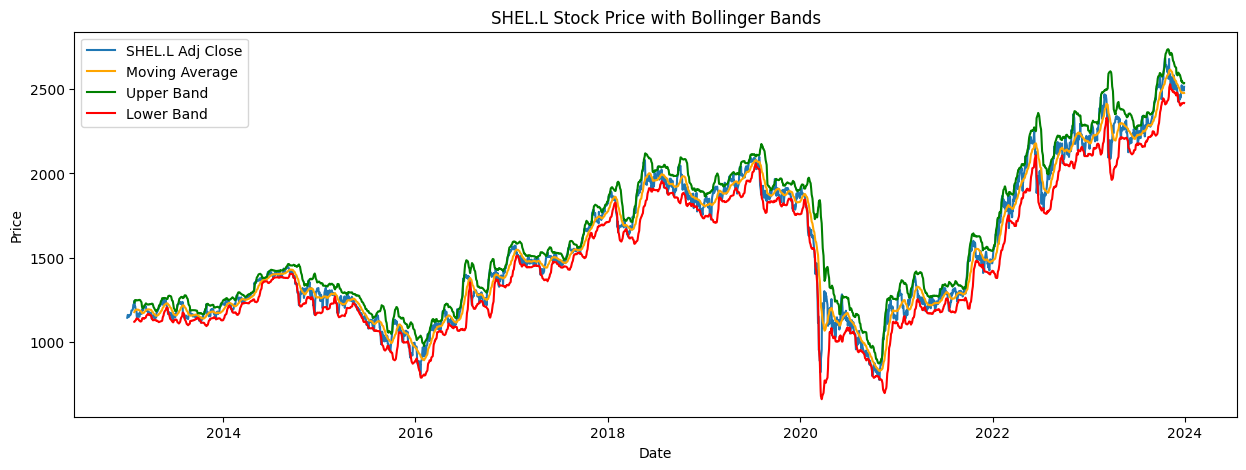

In [15]:
# Bollinger Bands parameters
window = 20
std_dev_factor = 2

# Calculate Bollinger Bands and plot for each stock
for stock in stocks:
    stock_data_subset = stock_data[stock_data['Stock'] == stock].copy()
    rolling_mean = stock_data_subset['Adj Close'].rolling(window=window).mean()
    rolling_std = stock_data_subset['Adj Close'].rolling(window=window).std()
    stock_data_subset[f'{stock}_Upper_Band'] = rolling_mean + std_dev_factor * rolling_std
    stock_data_subset[f'{stock}_Lower_Band'] = rolling_mean - std_dev_factor * rolling_std

    plt.figure(figsize=(15, 5))
    plt.plot(stock_data_subset.index, stock_data_subset['Adj Close'], label=f'{stock} Adj Close')
    plt.plot(stock_data_subset.index, rolling_mean, label='Moving Average', color='orange')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_Upper_Band'], label='Upper Band', linestyle='solid', color='green')
    plt.plot(stock_data_subset.index, stock_data_subset[f'{stock}_Lower_Band'], label='Lower Band', linestyle='solid', color='red')
    plt.title(f'{stock} Stock Price with Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [16]:
# Download Stock Data
def fetch_stock_data(symbol, start_date, end_date):
    return yf.download(symbol, start=start_date, end=end_date)

symbol = "VOD.L"
start_datee = "2013-01-01"
end_datee = "2023-12-31"
stock_VOD = fetch_stock_data(symbol, start_datee, end_datee)


[*********************100%%**********************]  1 of 1 completed


In [17]:
# Define Technical Indicator Functions
def moving_average(data, window=10):
    return data['Adj Close'].rolling(window=window).mean()

def exponential_moving_average(data, span=20):
    return data['Adj Close'].ewm(span=span, adjust=False).mean()

def macd(data):
    exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

def rsi(data, window=14):
    delta = data['Adj Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def bollinger_bands(data, window=20):
    ma = data['Adj Close'].rolling(window=window).mean()
    std = data['Adj Close'].rolling(window=window).std()
    bollinger_up = ma + (std * 2)
    bollinger_down = ma - (std * 2)
    return bollinger_up, bollinger_down


In [18]:
# Calculate Technical Indicators and Clean Data
stock_VOD['MA10'] = moving_average(stock_VOD, window=10)
stock_VOD['MA50'] = moving_average(stock_VOD, window=50)
stock_VOD['EMA'] = exponential_moving_average(stock_VOD, span=20)
stock_VOD['MACD'], stock_VOD['MACDSignal'], stock_VOD['MACDHist'] = macd(stock_VOD)
stock_VOD['RSI'] = rsi(stock_VOD, window=14)
stock_VOD['Bollinger_Up'], stock_VOD['Bollinger_Down'] = bollinger_bands(stock_VOD, window=20)

stock_VOD.dropna(inplace=True)
stock_VOD.head()


,Open,High,Low,Close,Adj Close,Volume,MA10,MA50,EMA,MACD,MACDSignal,MACDHist,RSI,Bollinger_Up,Bollinger_Down
Date,,,,,,,,,,,,,,,
2013-03-12,193.252197,194.008102,191.636093,192.887299,82.205170,75925775,77.714996,74.600974,76.903601,1.871430,0.880927,0.990504,80.080505,82.778740,68.203289
2013-03-13,192.001099,192.418106,189.550903,190.020096,80.983215,90708176,78.477062,74.821374,77.292136,1.955239,1.095789,0.859450,79.548632,83.414111,68.038933
2013-03-14,187.726303,192.991592,187.726303,192.418106,82.005226,111626481,79.321332,75.062657,77.741002,2.080147,1.292661,0.787486,79.132967,84.256238,67.952207
2013-03-15,192.835205,195.681595,190.176498,191.062698,81.427559,130848813,79.985639,75.268837,78.092102,2.108222,1.455773,0.652449,75.774004,84.898791,67.996178
2013-03-18,187.726303,194.075897,187.726303,192.835205,82.182968,98076665,80.752148,75.493679,78.481709,2.166453,1.597909,0.568544,81.446243,85.598471,68.102997


#**Data** **Preprocessing** **and** **Feature** **Engineering**

In [19]:
# Normalize Data for VOD.L Stock
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['Adj Close', 'MA10', 'MA50', 'EMA', 'MACD', 'MACDSignal', 'MACDHist', 'RSI', 'Bollinger_Up', 'Bollinger_Down']
VOD_scaled = scaler.fit_transform(stock_VOD[features])


In [21]:
# Create Sequences for LSTM/GRU/CNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # predicting 'Adj Close' price
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(VOD_scaled, seq_length)

# Split the  VOD.L Stock data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


#**Hyperparameter** **Tuning** **for** **LSTM**, **GRU**, **and** **LSTM**-**CNN**

In [22]:
# Define Model Building Functions
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_gru_model(hp):
    model = Sequential([
        GRU(units=hp.Int('units', min_value=50, max_value=150, step=50), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        GRU(units=hp.Int('units', min_value=50, max_value=150, step=50)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_lstm_cnn_model(hp):
    model = Sequential([
        Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(units=hp.Int('units', min_value=50, max_value=150, step=50)),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [25]:
# Initialize Tuners
tuner_lstm = RandomSearch(build_lstm_model, objective='val_loss', max_trials=3, executions_per_trial=1, directory='tuner_results', project_name='lstm_tuning')
tuner_gru = RandomSearch(build_gru_model, objective='val_loss', max_trials=3, executions_per_trial=1, directory='tuner_results', project_name='gru_tuning')
tuner_lstm_cnn = RandomSearch(build_lstm_cnn_model, objective='val_loss', max_trials=3, executions_per_trial=1, directory='tuner_results', project_name='lstm_cnn_tuning')



In [26]:
# Perform Hyperparameter Tuning
tuner_lstm.search(X_train, y_train, epochs=10, validation_split=0.2)
tuner_gru.search(X_train, y_train, epochs=10, validation_split=0.2)
tuner_lstm_cnn.search(X_train, y_train, epochs=10, validation_split=0.2)

best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]
best_gru_model = tuner_gru.get_best_models(num_models=1)[0]
best_lstm_cnn_model = tuner_lstm_cnn.get_best_models(num_models=1)[0]


Trial 3 Complete [00h 00m 09s]
val_loss: 0.0016218157252296805

Best val_loss So Far: 0.0011622533202171326
Total elapsed time: 00h 00m 30s


In [27]:
# Train Models with Best Hyperparameters
history_lstm = best_lstm_model.fit(X_train, y_train, epochs=50, validation_split=0.2)
history_gru = best_gru_model.fit(X_train, y_train, epochs=50, validation_split=0.2)
history_lstm_cnn = best_lstm_cnn_model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
54/54 [==============================] - 5s 23ms/step - loss: 7.0578e-04 - val_loss: 0.0011
Epoch 2/50
54/54 [==============================] - 0s 9ms/step - loss: 7.3823e-04 - val_loss: 0.0012
Epoch 3/50
54/54 [==============================] - 0s 9ms/step - loss: 6.2462e-04 - val_loss: 0.0011
Epoch 4/50
54/54 [==============================] - 0s 9ms/step - loss: 6.3382e-04 - val_loss: 9.3532e-04
Epoch 5/50
54/54 [==============================] - 1s 13ms/step - loss: 5.8029e-04 - val_loss: 9.5169e-04
Epoch 6/50
54/54 [==============================] - 1s 16ms/step - loss: 5.0889e-04 - val_loss: 8.7825e-04
Epoch 7/50
54/54 [==============================] - 1s 11ms/step - loss: 6.5407e-04 - val_loss: 0.0011
Epoch 8/50
54/54 [==============================] - 0s 9ms/step - loss: 5.6075e-04 - val_loss: 0.0017
Epoch 9/50
54/54 [==============================] - 0s 9ms/step - loss: 5.8069e-04 - val_loss: 9.2015e-04
Epoch 10/50
54/54 [==============================] - 1s 13ms/s

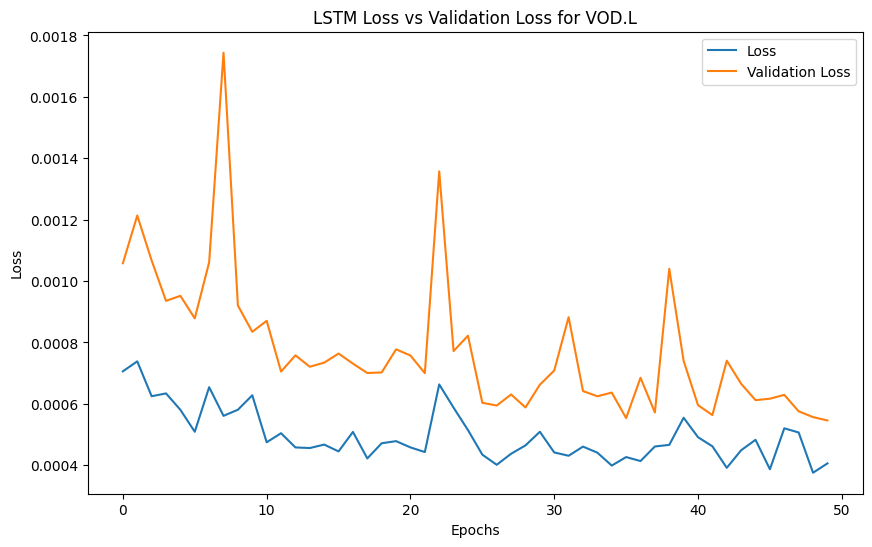

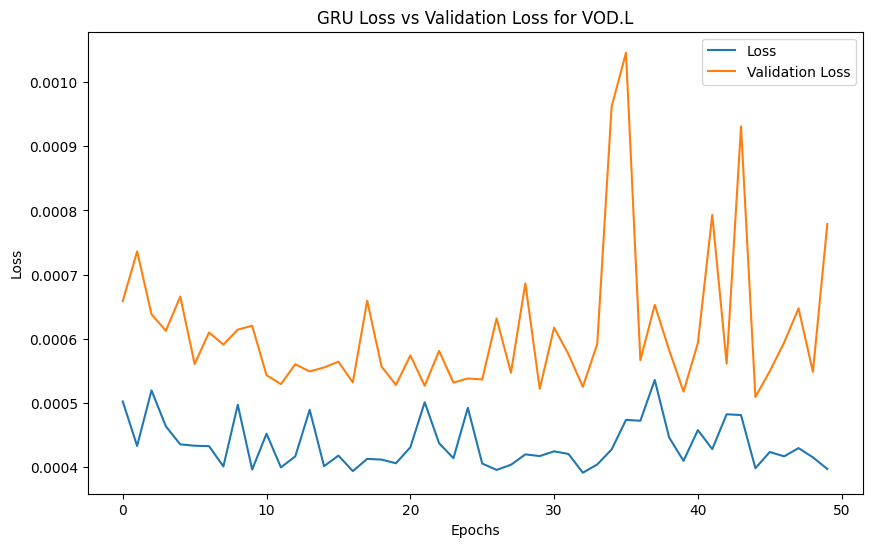

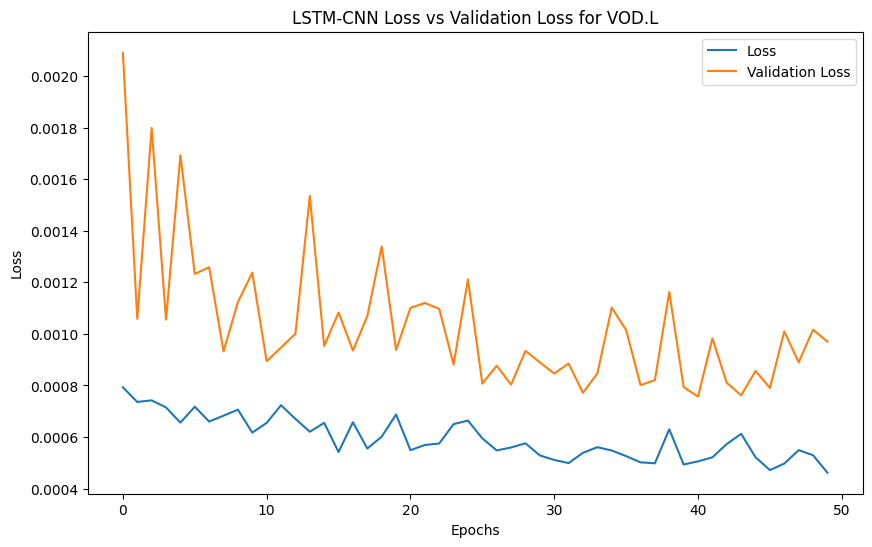

In [31]:
# Plot Loss and Validation Loss fro VOD.L Stock
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history_lstm, 'LSTM Loss vs Validation Loss for VOD.L')
plot_loss(history_gru, 'GRU Loss vs Validation Loss for VOD.L')
plot_loss(history_lstm_cnn, 'LSTM-CNN Loss vs Validation Loss for VOD.L')

In [29]:
# Make Predictions for VOD.L
y_pred_lstm = best_lstm_model.predict(X_test)
y_pred_gru = best_gru_model.predict(X_test)
y_pred_lstm_cnn = best_lstm_cnn_model.predict(X_test)

# Inverse transform predictions
y_test_rescaled = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), len(features)-1))])[:, 0]
y_pred_lstm_rescaled = scaler.inverse_transform(np.c_[y_pred_lstm, np.zeros((len(y_pred_lstm), len(features)-1))])[:, 0]
y_pred_gru_rescaled = scaler.inverse_transform(np.c_[y_pred_gru, np.zeros((len(y_pred_gru), len(features)-1))])[:, 0]
y_pred_lstm_cnn_rescaled = scaler.inverse_transform(np.c_[y_pred_lstm_cnn, np.zeros((len(y_pred_lstm_cnn), len(features)-1))])[:, 0]


17/17 [==============================] - 0s 5ms/step


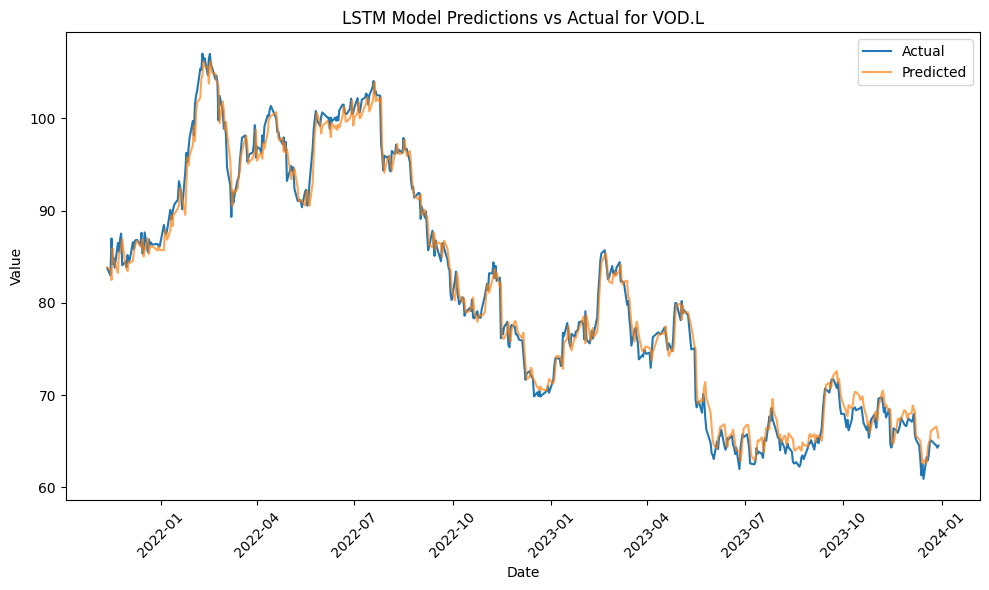

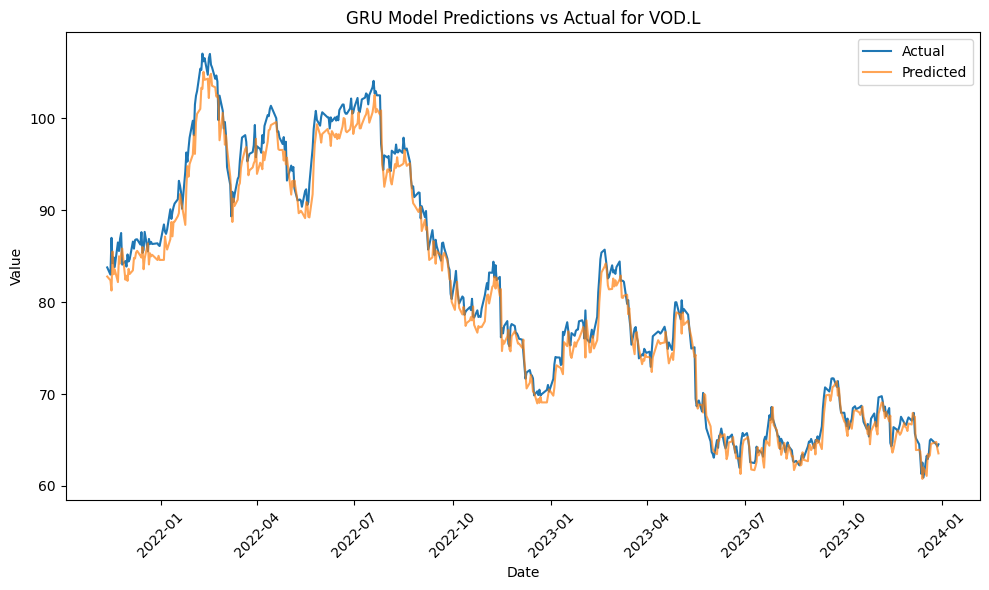

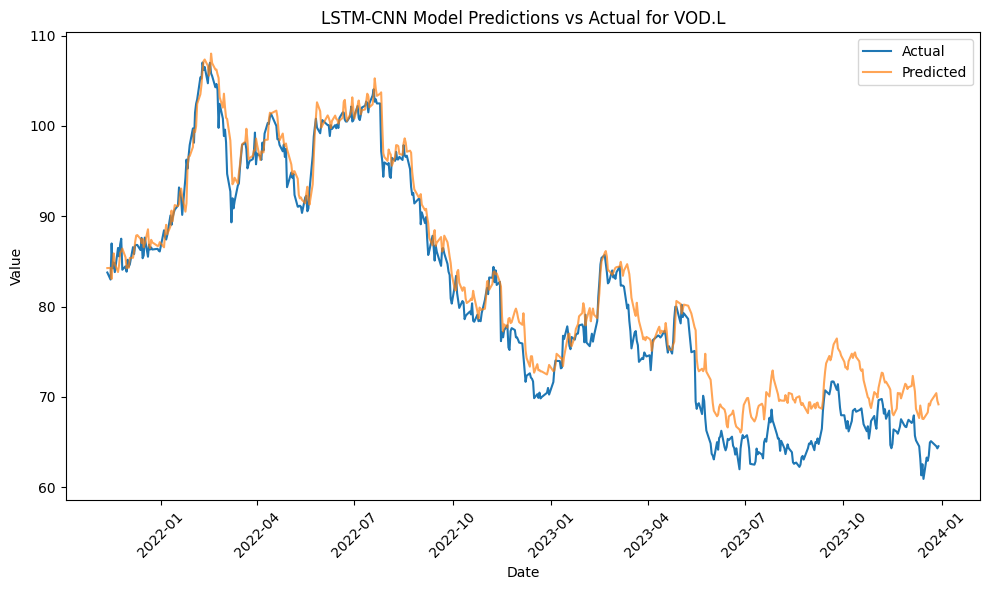

In [30]:
# Plot Predictions vs Actual Values
def plot_predictions(y_test, y_pred, title, dates):
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_test, label='Actual')
    plt.plot(dates, y_pred, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

dates = stock_VOD.index[-len(y_test_rescaled):]

plot_predictions(y_test_rescaled, y_pred_lstm_rescaled, 'LSTM Model Predictions vs Actual for VOD.L', dates)
plot_predictions(y_test_rescaled, y_pred_gru_rescaled, 'GRU Model Predictions vs Actual for VOD.L', dates)
plot_predictions(y_test_rescaled, y_pred_lstm_cnn_rescaled, 'LSTM-CNN Model Predictions vs Actual for VOD.L', dates)
